Extension of Example 2 to mixed sensitivity performance involving sensitivity and input sensitivity.
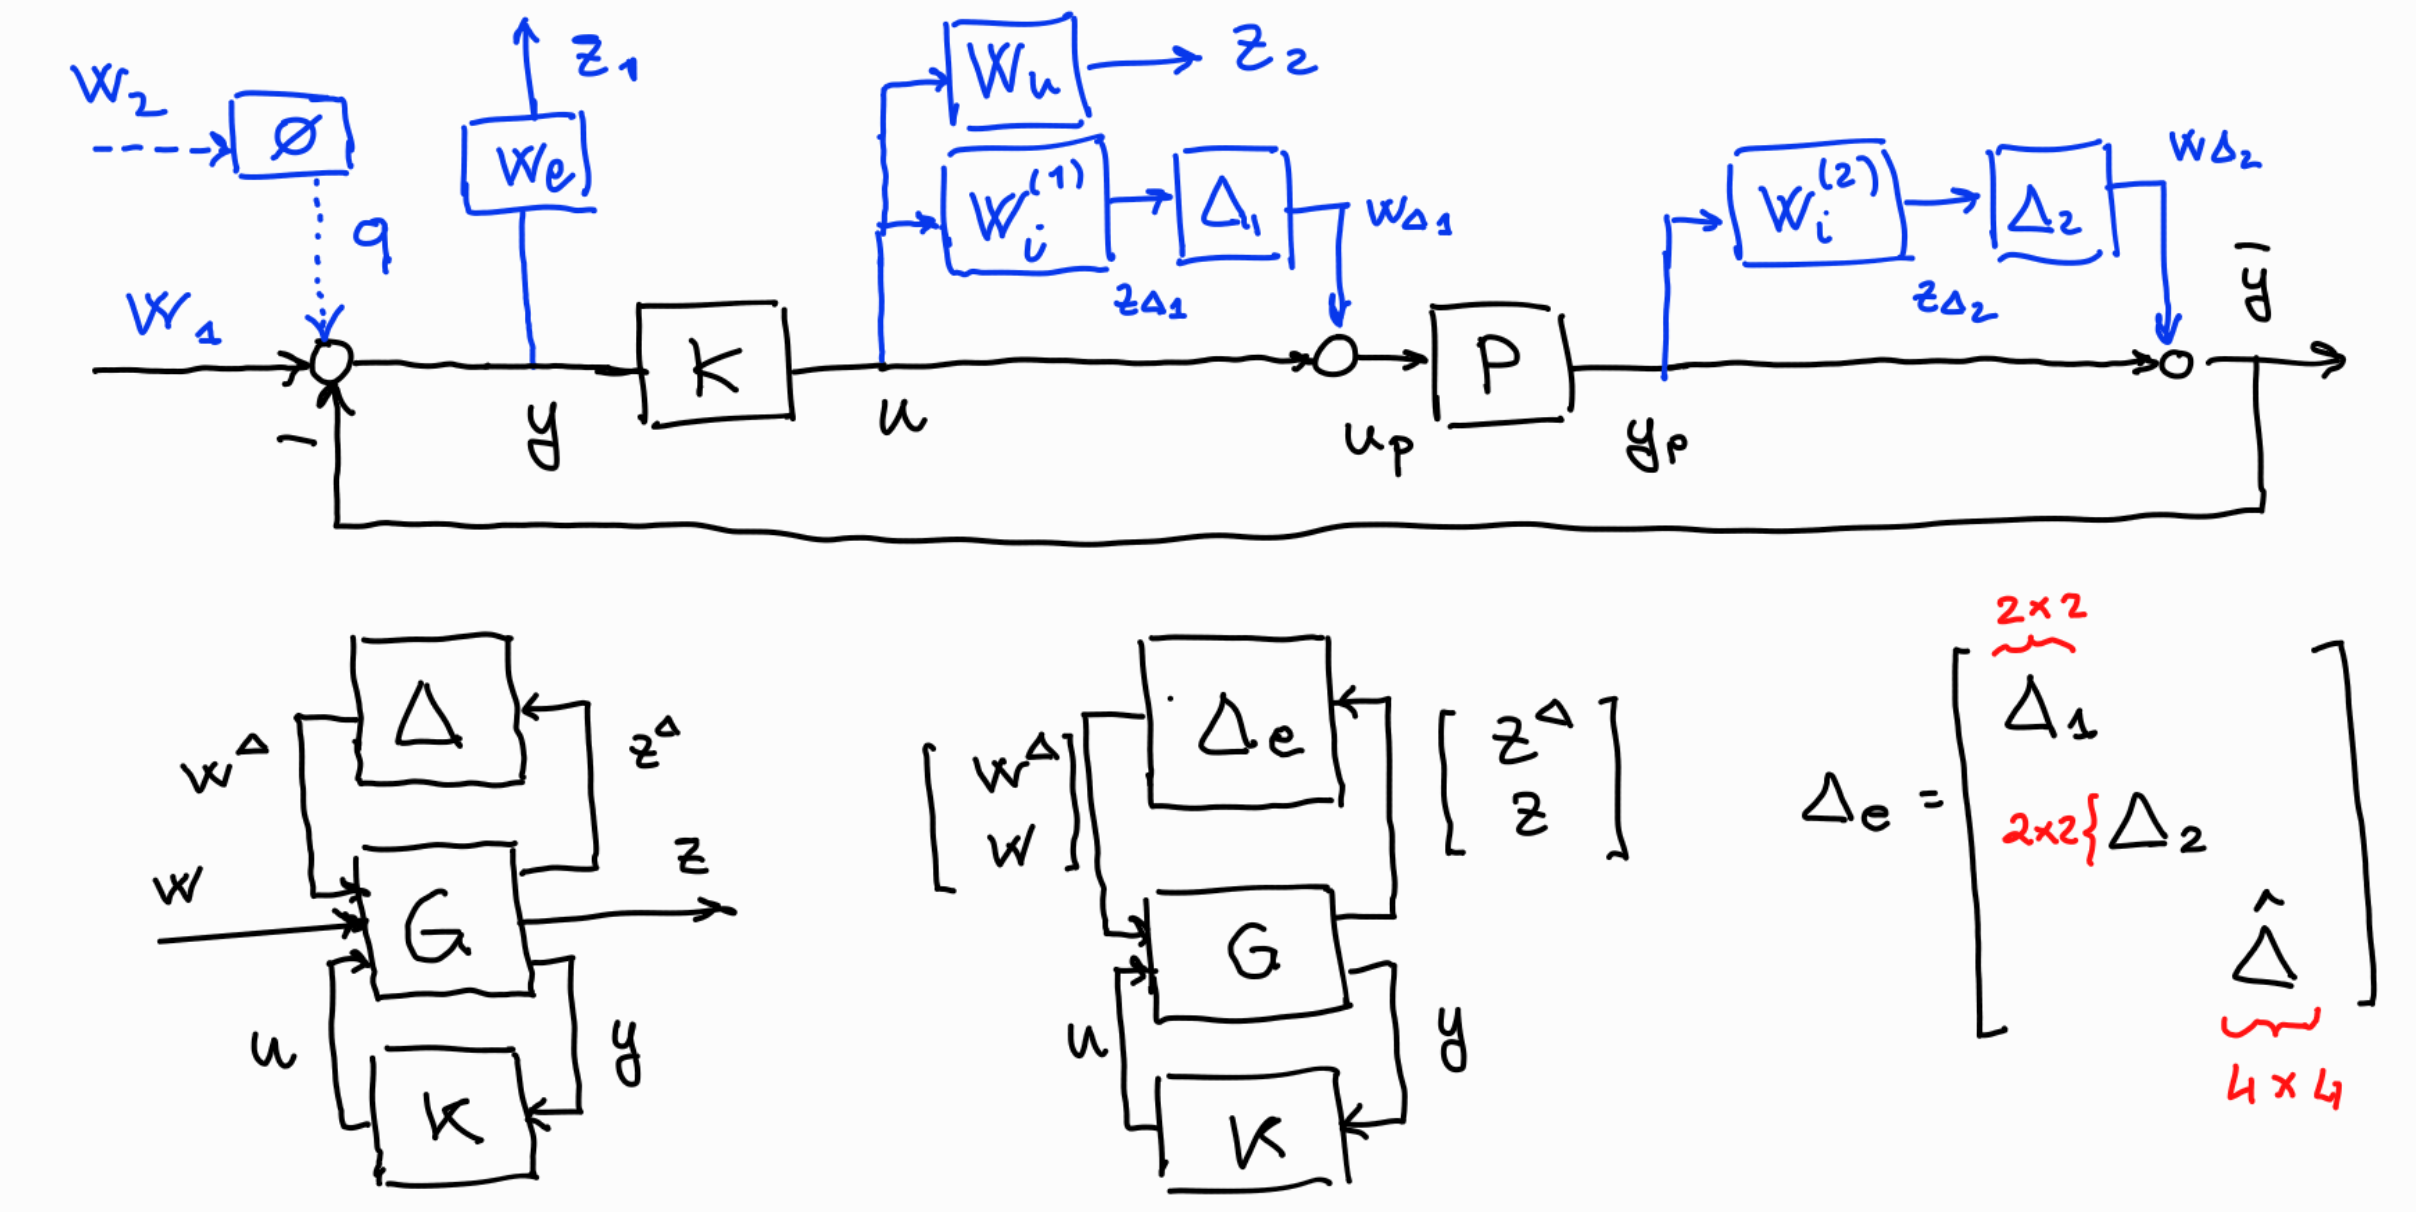

Plant uncertainty model is $P_p=(I+\Delta W_{i,2})P(I+\Delta W_{i,1})$, with $W_{i,1}=w_{i,1} I$, $W_{i,2}=w_{i,2} I$.

In [1]:
import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb
s= ct.tf('s')

In [2]:
# Plant P
den = [75, 1]
P = ct.tf([[[87.8], [-86.4]],
              [[108.2], [-109.6]]],
             [[den, den],
              [den, den]])
display("Plant transfer function", P)

'Plant transfer function'

TransferFunction(
[[array([87.8]), array([-86.4])],
 [array([108.2]), array([-109.6])]],
[[array([75,  1]), array([75,  1])],
 [array([75,  1]), array([75,  1])]],
outputs=2, inputs=2)

Define performance weight and uncertainty weight 

'Uncertainty weight'

TransferFunction(
[[array([1. , 0.2]), array([0.])],
 [array([0.]), array([1. , 0.2])]],
[[array([0.5, 1. ]), array([1.])],
 [array([1.]), array([0.5, 1. ])]],
outputs=2, inputs=2)

'Sensitivity performance weight'

TransferFunction(
[[array([0.375 , 0.0375]), array([0.])],
 [array([0.]), array([0.375 , 0.0375])]],
[[array([1.e+00, 1.e-06]), array([1.])],
 [array([1.]), array([1.e+00, 1.e-06])]],
outputs=2, inputs=2)

'Input sensitivity performance weight'

TransferFunction(
[[array([2.5e-01, 2.5e-07]), array([0.])],
 [array([0.]), array([2.5e-01, 2.5e-07])]],
[[array([0.5, 1. ]), array([1.])],
 [array([1.]), array([0.5, 1. ])]],
outputs=2, inputs=2)

Text(0.5, 1.0, 'Frequency response of performance weights We, Wu')

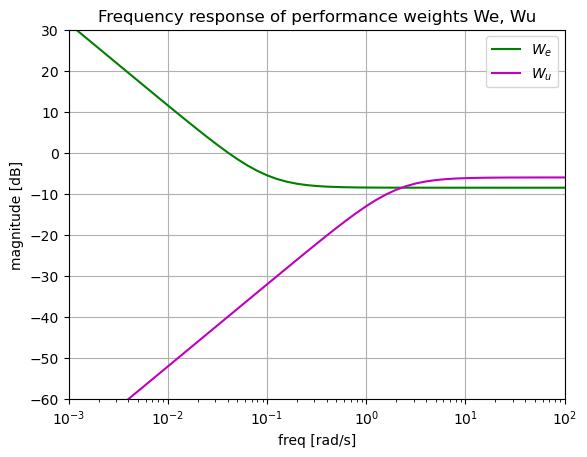

In [3]:
# Uncertainty block 1 weight Wi (uncertain input gain + neglected delay, see example 1)
w_i1 = ct.tf([1,0.2],[0.5,1])
Wi1 = w_i1.append(w_i1) 
display("Uncertainty weight", Wi1)

# Uncertainty block 2 weight Wi2 (uncertain output gain, nominal = 1)
Kmin = 0.9
Kmax = 1.1
Km = 0.5*(Kmin+Kmax)
alpha = (Kmax-Kmin)/2/Km
wi2_1 = ct.ss([],[],[],alpha)
Wi2 = wi2_1.append(wi2_1) 

# Performance weight We (weight on S)
w_e = 0.75*ct.tf([0.5,0.05],[1,1e-6])
We = w_e.append(w_e)
display("Sensitivity performance weight", We)

# Performance weight Wu (weight on KS)
w_u = 0.25*ct.tf([1,1e-6],[0.5,1])
Wu = w_u.append(w_u)
display("Input sensitivity performance weight", Wu)

# Frequency range for mu computations
omega = np.logspace(-3, 3, 61)

Wesv = rb.sigma(w_e, omega)
Wusv = rb.sigma(w_u, omega)

plt.semilogx(omega, 20*np.log10(Wesv[:, 0]), 'g', label=r'$W_e$')
plt.semilogx(omega, 20*np.log10(Wusv[:, 0]), 'm', label=r'$W_u$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Frequency response of performance weights We, Wu')

Construct the LFT. Since the $\mu$-synthesis software only works with square $G$, we formulate the mixed sensitivity problem from $[w_1~w_2]'$ to $[z_1~z_2]'$, where $w_2$ is a dummy input that enters the system via a zero gain block $W_d$, so that the gain from $[w_1~w_2]'$ to $[z_1~z_2]'$ is the same as the gain from $w_1$ to $[z_1~z_2]'$ (see figure).

In [4]:
# This is a dummy zero performance filter to make the robust performance problem square (see figure)
w_d = ct.ss([],[],[],0)
Wd = w_d.append(w_d)

Wd.input_labels = ['w2[0]', 'w2[1]']
Wd.output_labels = ['q[0]', 'q[1]']
Wu.input_labels = ['u[0]', 'u[1]']
Wu.output_labels = ['z2[0]', 'z2[1]']
Wi1.input_labels = ['u[0]', 'u[1]']
Wi1.output_labels = ['zdelta1[0]', 'zdelta1[1]']
Wi2.input_labels = ['yp[0]', 'yp[1]']
Wi2.output_labels = ['zdelta2[0]', 'zdelta2[1]']
We.input_labels = ['y[0]', 'y[1]']
We.output_labels = ['z1[0]', 'z1[1]']
P.input_labels = ['up[0]','up[1]']
P.output_labels = ['yp[0]','yp[1]']

# Summing junctions from uncertain blocks
sumdelta1 = ct.summing_junction(inputs=['u','wdelta1'], output='up', dimension=2)
sumdelta2 = ct.summing_junction(inputs=['yp','wdelta2'], output='ybar', dimension=2)

# Feedback: y = r-ybar+q (q is always zero)
fbk = ct.summing_junction(inputs=['w1','-ybar','q'], output='y', dimension=2)

# Generate the G transfer function of the LFT
G = ct.minreal(ct.interconnect([P, Wi1, Wi2, We, Wu, sumdelta1, sumdelta2, fbk, Wd],
                    inputs=['wdelta1[0]','wdelta1[1]','wdelta2[0]','wdelta2[1]','w1[0]','w1[1]','w2[0]','w2[1]','u[0]','u[1]'],
                    outputs=['zdelta1[0]','zdelta1[1]','zdelta2[0]','zdelta2[1]','z1[0]','z1[1]','z2[0]','z2[1]','y[0]','y[1]']), 
                    verbose=False)

Do $\mu$-synthesis

In [5]:
# Controller I/O sizes
f = 2

# Extended uncertainty structure: two 2x2 uncertainty blocks and a 4x4 performance block
nblock = np.array([2,2,4])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2,2])

# Do mu-synthesis via D-K iteration
# Note that we enforce reduction on the closed loop of each iteration. If we don't, numerical problems arise
# for this problem instance
K, best_nubar, init_mubar, best_mubar, gamma = rb.musyn(G, f, nblock, itype, omega)

display("Best upper bound (nubar) to mu norm of Tzw_delta: ", best_nubar)

Infinity norm of Tzw_delta with initial Hinfinity controller:  1.1904531547202168
Iteration # 1
Best upper bound to mu norm of Tzw_delta:  1.0974734837544466
Iteration # 2
Best upper bound to mu norm of Tzw_delta:  0.9924827705337628
Iteration # 3
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1.0
Iteration # 4
No better upper bound to mu norm of Tzw_delta found: trying D order  6 qutol  1.0
Iteration # 5
No better upper bound to mu norm of Tzw_delta found: trying D order  7 qutol  1.0
Iteration # 6
No better upper bound to mu norm of Tzw_delta found: trying D order  8 qutol  1.0
Iteration # 7
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2.0
Iteration # 8
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  2.0
Iteration # 9
No better upper bound to mu norm of Tzw_delta found: trying D order  6 qutol  2.0
Iteration # 10
No better upper bound to mu norm of Tzw_delta found: trying D order  7 qutol  2

'Best upper bound (nubar) to mu norm of Tzw_delta: '

0.9924827705337628

Plot initial and final $\mu$ upper bound $\bar\mu$ with frequency

Text(0.5, 1.0, 'Initial and final $\\bar\\mu$')

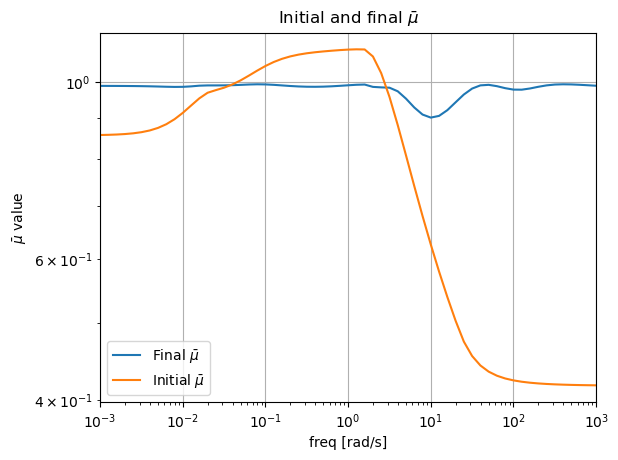

In [6]:
plt.loglog(omega, best_mubar, label=r'Final $\bar \mu$')
plt.loglog(omega, init_mubar, label=r'Initial $\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.xlim([1e-3, 1e3])
plt.legend()
plt.grid()
plt.title(r'Initial and final $\bar\mu$')

Verify performance on the nominal system. It must hold that $\|W_e S\|_\infty \leq \bar\nu$, and $\|W_u KS\|_\infty \leq \bar\nu$. 

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for the nominal system')

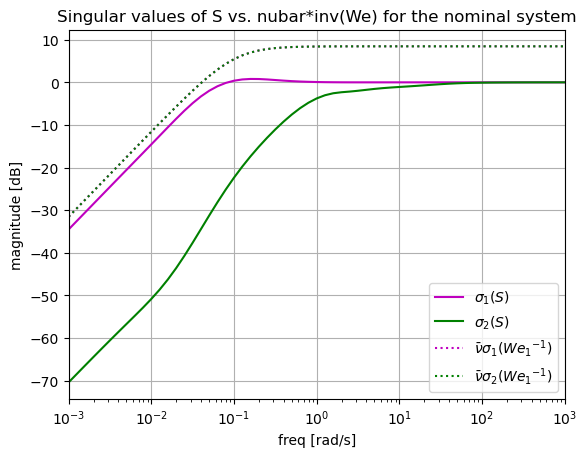

In [7]:
# Compute closed loop sensitivity for the nominal system
I = ct.ss([], [], [], np.eye(2)) # Identity system  
Delta1 = 0 * I
Delta2 = 0 * I
Delta1.input_labels = ['zdelta1[0]','zdelta1[1]']
Delta1.output_labels = ['wdelta1[0]','wdelta1[1]']   
Delta2.input_labels = ['zdelta2[0]','zdelta2[1]']
Delta2.output_labels = ['wdelta2[0]','wdelta2[1]'] 
K.input_labels = ['y[0]','y[1]']
K.output_labels = ['u[0]','u[1]'] 

S = ct.minreal(ct.interconnect([P, Delta1, Delta2, K, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk, Wu, Wd],
                    inputs=['w1[0]','w1[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Ssv = rb.sigma(S, omega)

# We plot the singular values of gamma*invss(We) along with S
# for gamma = best_nubar
Weinv = rb.invss(ct.ss(We))
Weinvsv = rb.sigma(Weinv, omega) * best_nubar

plt.semilogx(omega, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({We_1}^{-1})$')
#plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for the nominal system')


Text(0.5, 1.0, 'Singular values of KS vs. nubar*inv(Wu) for the nominal system')

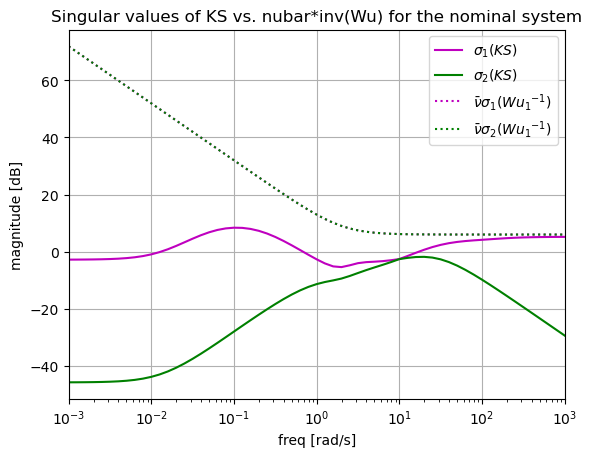

In [8]:
# Compute closed loop input sensitivity for the nominal system
KS = ct.minreal(ct.interconnect([P, Delta1, Delta2, K, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk, Wu, Wd],
                    inputs=['w1[0]','w1[1]'],
                    outputs=['u[0]','u[1]'], check_unused=False), verbose=False)

# Compute singular values of KS over frequency
KSsv = rb.sigma(KS, omega)

# We plot the singular values of gamma*invss(Wu) along with KS
# for gamma = best_nubar
Wuinv = rb.invss(ct.ss(Wu))
Wuinvsv = rb.sigma(Wuinv, omega) * best_nubar

plt.semilogx(omega, 20*np.log10(KSsv[:, 0]), 'm', label=r'$\sigma_1(KS)$')
plt.semilogx(omega, 20*np.log10(KSsv[:, 1]), 'g', label=r'$\sigma_2(KS)$')
plt.semilogx(omega, 20*np.log10(Wuinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({Wu_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Wuinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({Wu_1}^{-1})$')
#plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of KS vs. nubar*inv(Wu) for the nominal system')

Verify performance on the perturbed system. It must hold that $\|W_e S\|_\infty \leq \bar\nu$, and $\|W_u KS\|_\infty \leq \bar\nu$ as well. 

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for the nominal system')

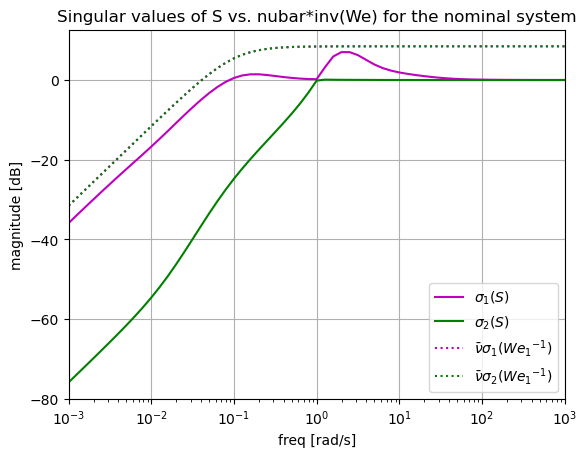

In [9]:
# Generate an admissible perturbed plant
Dp = 1/best_nubar * ct.tf([-1,0.2],[0.5,1])
Dp = Dp.append(Dp)

Pp = (I+0.1/best_nubar*I) * P * (I+Dp)
Pp.input_labels = ['up[0]','up[1]']
Pp.output_labels = ['yp[0]','yp[1]']

S = ct.minreal(ct.interconnect([Pp, Delta1, Delta2, K, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk, Wu, Wd],
                    inputs=['w1[0]','w1[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)
KS = ct.minreal(ct.interconnect([Pp, Delta1, Delta2, K, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk, Wu, Wd],
                    inputs=['w1[0]','w1[1]'],
                    outputs=['u[0]','u[1]'], check_unused=False), verbose=False)

# Compute singular values of S and KS over frequency
Ssv = rb.sigma(S, omega)
KSsv = rb.sigma(KS, omega)

# We plot the singular values of gamma*invss(We) along with S
# for gamma = best_nubar
plt.semilogx(omega, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({We_1}^{-1})$')
#plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of S vs. nubar*inv(We) for the nominal system')
# We plot the singular values of gamma*invss(We) along with S
# for gamma = best_nubar

Text(0.5, 1.0, 'Singular values of KS vs. nubar*inv(Wu) for the nominal system')

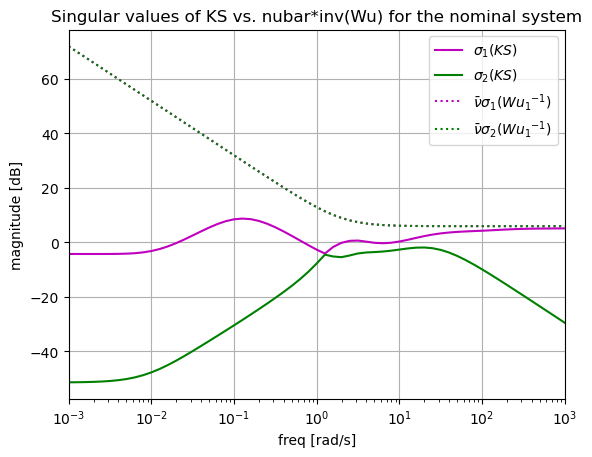

In [10]:
# We plot the singular values of gamma*invss(Wu) along with KS
# for gamma = best_nubar
plt.semilogx(omega, 20*np.log10(KSsv[:, 0]), 'm', label=r'$\sigma_1(KS)$')
plt.semilogx(omega, 20*np.log10(KSsv[:, 1]), 'g', label=r'$\sigma_2(KS)$')
plt.semilogx(omega, 20*np.log10(Wuinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({Wu_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Wuinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({Wu_1}^{-1})$')
#plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('Singular values of KS vs. nubar*inv(Wu) for the nominal system')